# PVGIS Global Irradiance Map

#### Import Project Scripts

In [1]:
from scripts.create_lat_lon import create_gdf
from scripts.utils.geoprocessing_utils import square_grid
from scripts.utils.geodata_download import create_gisco_gdf
from scripts.utils.plot_points_and_polygons import plot_points_and_ine_municipalities, plot_points_and_countries

#### Import libraries

In [2]:
import os
import folium
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

#### Localhost DB Connection

In [3]:
from scripts.db_clickhouse.clickhouse_management import conn_clickhouse
from scripts.db_clickhouse import sql_functions
client = conn_clickhouse()

#### Set preferences

In [4]:
xmin = -4.59
ymin = 40.05
xmax = -3.19
ymax = 41.2

srid = 4326

#### Create a grid of points by bounding box

In [5]:
points_gdf = create_gdf(xmin, ymin, xmax, ymax, srid)
points_gdf.head()

-459.0 -319.0 4004.9999999999995 4120.0
-459 -319 4005 4120


,lat,lon,geometry
0,40.05,-4.59,POINT (-4.59000 40.05000)
1,40.05,-4.54,POINT (-4.54000 40.05000)
2,40.05,-4.49,POINT (-4.49000 40.05000)
3,40.05,-4.44,POINT (-4.44000 40.05000)
4,40.05,-4.39,POINT (-4.39000 40.05000)


#### Create a square grid with side and point center

In [6]:
grid_gdf = square_grid(points_gdf, 0.05)
grid_gdf.head()

,lat,lon,geometry
0,40.05,-4.59,"POLYGON ((-4.56500 40.02500, -4.56500 40.07500..."
1,40.05,-4.54,"POLYGON ((-4.51500 40.02500, -4.51500 40.07500..."
2,40.05,-4.49,"POLYGON ((-4.46500 40.02500, -4.46500 40.07500..."
3,40.05,-4.44,"POLYGON ((-4.41500 40.02500, -4.41500 40.07500..."
4,40.05,-4.39,"POLYGON ((-4.36500 40.02500, -4.36500 40.07500..."


#### Plot grid of points

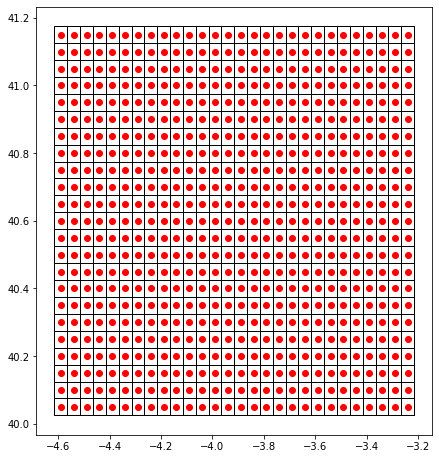

In [16]:
f, ax = plt.subplots(1)
grid_gdf.plot(ax=ax, color='white', edgecolor='black')
points_gdf.plot(ax=ax, color='red')
plt.rcParams['figure.figsize'] = [5/2.54, 5/2.54]
plt.show()

#### Calculate Anual Global Irradiance 

In [8]:
query = " \
            SELECT \
                latitude, \
                longitude, \
                toYear(time) AS date, \
                ROUND(SUM(global_irradiance) / 1000, 2) AS golbal_irradiance \
             \
            FROM seriescalc \
            WHERE toYear(time) = 2016 \
            GROUP BY latitude, longitude, toYear(time) \
        "

gi_2016_df = client.query_dataframe(query)

gi_2016_df.head()

,latitude,longitude,date,golbal_irradiance
0,41.10,-4.29,2016,1686.77
1,40.70,-4.54,2016,1674.85
2,40.90,-3.14,2016,1685.09
3,39.85,-3.14,2016,1778.40
4,40.75,-4.19,2016,1679.55


#### Merge Polygons and GIobal Irradiance by latitude and longitude

In [9]:
grid_gi_2016 = grid_gdf.merge(gi_2016_df, left_on=['lat','lon'], right_on=['latitude','longitude'])
del grid_gi_2016['lat']
del grid_gi_2016['lon']

grid_gi_2016.head()

,geometry,latitude,longitude,date,golbal_irradiance
0,"POLYGON ((-4.56500 40.02500, -4.56500 40.07500...",40.05,-4.59,2016,1687.06
1,"POLYGON ((-4.51500 40.02500, -4.51500 40.07500...",40.05,-4.54,2016,1687.13
2,"POLYGON ((-4.46500 40.02500, -4.46500 40.07500...",40.05,-4.49,2016,1700.89
3,"POLYGON ((-4.41500 40.02500, -4.41500 40.07500...",40.05,-4.44,2016,1700.88
4,"POLYGON ((-4.36500 40.02500, -4.36500 40.07500...",40.05,-4.39,2016,1700.65


#### Choropleth maps

In [13]:
# Create an ID
grid_gi_2016["id"] = grid_gi_2016.index + 1
grid_gi_2016.head()

# Set Geo Data
grid_gi_2016_geo = grid_gi_2016.to_json() # geojson format

# create a plain world map
x0 = (xmin + xmax) / 2
y0 = (ymin + ymax) / 2
m = folium.Map(location=[y0, x0], zoom_start=8, tiles='CartoDB positron')

# generate choropleth map 
folium.Choropleth(
    geo_data=grid_gi_2016_geo,
    name="choropleth",
    data=grid_gi_2016,
    columns=["id", "golbal_irradiance"],
    key_on="feature.properties.id",
    fill_color="OrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="2016 Anual Global Irradiance (KWh/m2)",
).add_to(m)

folium.LayerControl().add_to(m)

In [14]:
# display map
m

#### Anual Monthly Series Global Irradiance (KWh/m2)

In [11]:
mgi_anual_df = pd.DataFrame()

for year in range(2005, 2017):
    mgi_anual_df = mgi_anual_df.append(sql_functions.anual_monthly_series_gi(year, client))

mgi_anual_df.head()

,year,month,global_irradiance
0,2005,1,83.321926
1,2005,2,86.392691
2,2005,3,136.781321
3,2005,4,174.194827
4,2005,5,204.154346


#### Chart Visualization

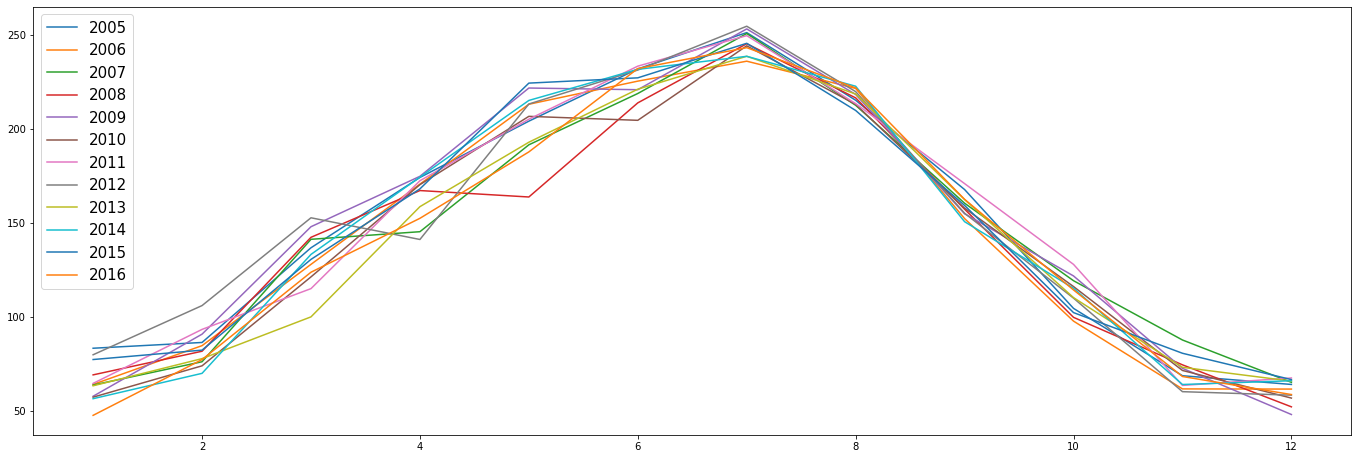

In [15]:
# Define data values
x = list(mgi_anual_df['month'].drop_duplicates())

for year in range(2005, 2017):
    # Iterate plotting a simple line chart
    a = mgi_anual_df[mgi_anual_df['year']==year]
    y = list(pd.Series(a['global_irradiance'].values, index=a['month']))
    plt.plot(x, y, label=str(year))

plt.rcParams['figure.figsize'] = [60/2.54, 20/2.54]
plt.legend(loc="upper left", fontsize=15)
plt.show()